# Lecture 8 - Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Build an intuition for a **neuron**, **activation**, **layers**, and **loss**.
- See why linear models from Lecture 5 need help on nonlinear patterns.
- Train a first **neural network** for a toy problem, then for chemistry data.
- Use **MLPRegressor** and **MLPClassifier** with scaling, early stopping, and basic tuning.
- Read **loss curves**, **parity plots**, and **classification metrics**.
- Practice with short exercises between steps and a final in‑class activity.

---

## 0. Setup

In [1]:
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try RDKit for descriptors. If unavailable, we will continue with numeric columns only.
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="X has feature names")
np.set_printoptions(precision=3, suppress=True)

---

## 1. From linear to nonlinear

```{admonition} Recap from Lectures 5 to 7
- Linear regression and logistic regression use a straight-line boundary in feature space.
- Trees and forests cut space into rectangles by splitting on features.
- Some patterns cannot be captured by a single line. We need **nonlinear** functions.
```

A **neural network** builds nonlinear functions by stacking simple blocks:

- Linear transform: \( z = W x + b \)
- Activation: \( a = \phi(z) \) where \(\phi\) is a nonlinearity such as `relu` or `tanh`
- Repeat across layers and learn the weights from data by minimizing a **loss**.

### 1.1 A tiny activation tour

In [2]:
# Simple view of activations on a vector
x = np.linspace(-3, 3, 7)
relu = np.maximum(0, x)
tanh = np.tanh(x)
sigm = 1 / (1 + np.exp(-x))
pd.DataFrame({"x": x, "relu(x)": relu, "tanh(x)": tanh, "sigmoid(x)": sigm})

,x,relu(x),tanh(x),sigmoid(x)
0,-3.0,0.0,-0.995055,0.047426
1,-2.0,0.0,-0.964028,0.119203
2,-1.0,0.0,-0.761594,0.268941
3,0.0,0.0,0.000000,0.500000
4,1.0,1.0,0.761594,0.731059
5,2.0,2.0,0.964028,0.880797
6,3.0,3.0,0.995055,0.952574


```{admonition} Tip
- `relu` keeps positive parts and zeros negatives. Often trains fast.
- `tanh` squashes to [-1, 1]. Works well for small problems and smooth signals.
- `logistic` (sigmoid) squashes to [0, 1]. Common in small networks or output layers for probability.
```

---

## 2. Toy example: XOR shows the need for a hidden layer

XOR is a classic 2D classification where linear models fail. A small hidden layer fixes it.

### 2.1 Build XOR data

In [3]:
# Four points and labels for XOR
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y_xor = np.array([0,1,1,0], dtype=int)

X_xor, y_xor

(array([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]),
 array([0, 1, 1, 0]))

### 2.2 Visualize points

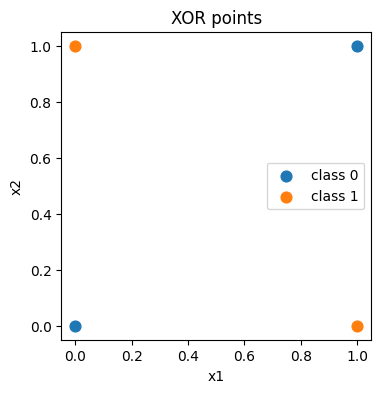

In [4]:
plt.figure(figsize=(4,4))
plt.scatter(X_xor[y_xor==0,0], X_xor[y_xor==0,1], label="class 0", s=60)
plt.scatter(X_xor[y_xor==1,0], X_xor[y_xor==1,1], label="class 1", s=60)
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.title("XOR points")
plt.show()

### 2.3 Baseline with logistic regression

In [5]:
logr = LogisticRegression().fit(X_xor, y_xor)
pred_lr = logr.predict(X_xor)
print("Logistic accuracy on XOR:", accuracy_score(y_xor, pred_lr))
confusion_matrix(y_xor, pred_lr)

Logistic accuracy on XOR: 0.5


array([[2, 0],
       [2, 0]], dtype=int64)

The score is low because a single line cannot separate the classes.

### 2.4 One hidden layer solves XOR

In [6]:
mlp_xor = MLPClassifier(
    hidden_layer_sizes=(4,),
    activation="tanh",
    solver="lbfgs",
    random_state=0
).fit(X_xor, y_xor)

pred_nn = mlp_xor.predict(X_xor)
print("MLP accuracy on XOR:", accuracy_score(y_xor, pred_nn))
confusion_matrix(y_xor, pred_nn)

MLP accuracy on XOR: 1.0


array([[2, 0],
       [0, 2]], dtype=int64)

### 2.5 Peek at learned shapes

In [7]:
# coefs_ is a list: one weight matrix per layer
[w.shape for w in mlp_xor.coefs_], [b.shape for b in mlp_xor.intercepts_]

([(2, 4), (4, 1)], [(4,), (1,)])

Interpretation:
- Input to hidden: shape (2, 4) because we have 2 inputs and 4 hidden units.
- Hidden to output: shape (4, 1) because we have 4 hidden units and 1 output.

```{admonition} Exercise 2.1
Change `hidden_layer_sizes` to `(2,)`, `(8,)`, and `(8, 8)`.  
Use `activation="relu"` once and compare accuracy.
```

```{admonition} Exercise 2.2
Add slight Gaussian noise to the four XOR points using `X_noisy = X_xor + 0.05*np.random.randn(*X_xor.shape)`  
Retrain the MLP and see if the decision remains correct.
```

---

## 3. A first regression network on a smooth function

We will fit \( y = \sin(2\pi x) + \text{noise} \) to contrast a linear regressor and a small MLP.

### 3.1 Make data

In [8]:
rng = np.random.RandomState(42)
x = np.linspace(0, 1, 80).reshape(-1, 1)
y = np.sin(2*np.pi*x).ravel() + 0.1*rng.randn(len(x))
pd.DataFrame({"x": x.ravel()[:5], "y": y[:5]})

,x,y
0,0.000000,0.049671
1,0.012658,0.065624
2,0.025316,0.223167
3,0.037975,0.388647
4,0.050633,0.289381


### 3.2 Plot the data

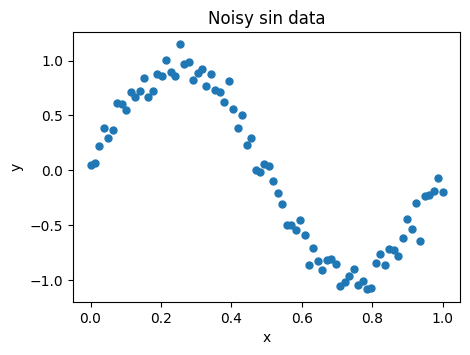

In [9]:
plt.figure(figsize=(5,3.5))
plt.scatter(x, y, s=25)
plt.xlabel("x"); plt.ylabel("y"); plt.title("Noisy sin data")
plt.show()

### 3.3 Linear baseline

In [10]:
lin = LinearRegression().fit(x, y)
y_lin = lin.predict(x)
print("Linear R2:", r2_score(y, y_lin))

Linear R2: 0.595209043110168


### 3.4 Small MLP with standardization and early stopping

In [11]:
mlp_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(20,),
        activation="tanh",
        solver="adam",
        learning_rate_init=0.01,
        max_iter=500,
        random_state=0,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20
    ))
]).fit(x, y)

y_mlp = mlp_reg.predict(x)
print("MLP R2:", r2_score(y, y_mlp))

MLP R2: 0.9742240223189593


### 3.5 Visualize predictions

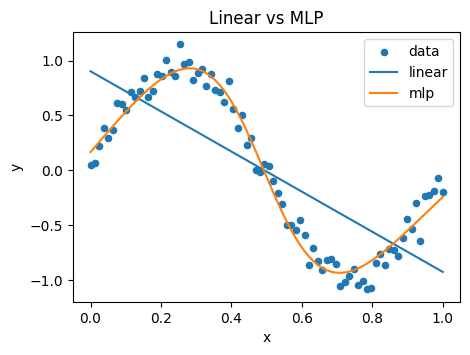

In [12]:
plt.figure(figsize=(5,3.5))
plt.scatter(x, y, s=20, label="data")
plt.plot(x, y_lin, label="linear")
plt.plot(x, y_mlp, label="mlp")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Linear vs MLP")
plt.legend(); plt.show()

```{admonition} Exercise 3.1
Change `activation` to `relu` and `hidden_layer_sizes` to `(50,)`.  
Compare the R2 and the curve shape.
```

```{admonition} Exercise 3.2
Reduce `learning_rate_init` to `0.001` and increase `max_iter` to `1000`.  
Check if the training loss decreases more smoothly.
```

---

## 4. Chemistry dataset again: descriptors plus targets

We return to the C–H oxidation dataset used in earlier lectures.

### 4.1 Load and compute descriptors

```{admonition} Data source
`https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv`
```

In [13]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
len(df_raw), df_raw.head(2)

(575,
                 Compound Name       CAS                  SMILES  \
 0  3,4-dihydro-1H-isochromene  493-05-0        c1ccc2c(c1)CCOC2   
 1                 9H-fluorene   86-73-7  c1ccc2c(c1)Cc1ccccc1-2   
 
    Solubility_mol_per_L   pKa   Toxicity  Melting Point  Reactivity  \
 0              0.103906  5.80  non_toxic           65.8           1   
 1              0.010460  5.82      toxic           90.0           1   
 
   Oxidation Site  
 0           8,10  
 1              7  )

In [14]:
def calc_descriptors(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)
df.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0


```{admonition} Reminder
These four descriptors have been our simple, reliable baseline features:
`MolWt`, `LogP`, `TPSA`, `NumRings`.
```

---

## 5. Regression: melting point with a small MLP

We will predict **Melting Point** from the four descriptors. Then we will compare to Ridge from Lecture 6.

### 5.1 Prepare features and target

In [15]:
df_reg = df[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
X = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]].values
y = df_reg["Melting Point"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((460, 4), (115, 4))

### 5.2 Baseline Ridge

In [16]:
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
y_ridge = ridge.predict(X_test)
print(f"Ridge R2: {r2_score(y_test, y_ridge):.3f}  MAE: {mean_absolute_error(y_test, y_ridge):.2f}")

Ridge R2: 0.874  MAE: 15.32


### 5.3 MLPRegressor with scaling and early stopping

In [17]:
mlp_mp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64,),
        activation="relu",
        solver="adam",
        learning_rate_init=0.005,
        alpha=1e-4,             # L2 penalty (weight decay)
        max_iter=800,
        early_stopping=True,    # use a validation split automatically
        validation_fraction=0.12,
        n_iter_no_change=25,
        random_state=0
    ))
]).fit(X_train, y_train)

y_hat = mlp_mp.predict(X_test)
print(f"MLP R2: {r2_score(y_test, y_hat):.3f}  MAE: {mean_absolute_error(y_test, y_hat):.2f}")

MLP R2: 0.867  MAE: 15.54


### 5.4 Parity and residuals

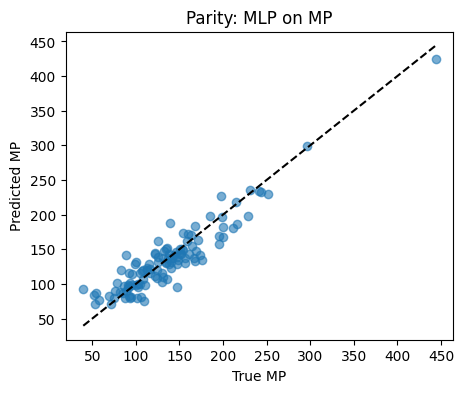

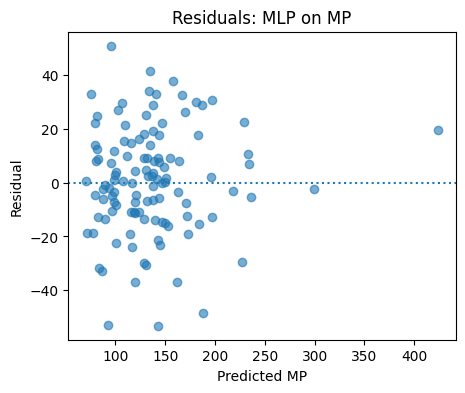

In [18]:
# Parity
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_hat, alpha=0.6)
lims = [min(y_test.min(), y_hat.min()), max(y_test.max(), y_hat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP"); plt.ylabel("Predicted MP"); plt.title("Parity: MLP on MP")
plt.show()

# Residuals
res = y_test - y_hat
plt.figure(figsize=(5,4))
plt.scatter(y_hat, res, alpha=0.6)
plt.axhline(0, ls=":")
plt.xlabel("Predicted MP"); plt.ylabel("Residual")
plt.title("Residuals: MLP on MP")
plt.show()

```{admonition} Exercise 5.1
Change `hidden_layer_sizes` to `(32,)` and `(64, 32)`.  
Compare R2 and MAE to the current model.
```

```{admonition} Exercise 5.2
Increase `alpha` to `1e-3` and `1e-2`.  
Is the model more stable across runs or does it start to underfit?
```

---

## 6. Classification: toxicity with a small MLP

We will predict the **Toxicity** label. This is a binary classification.

### 6.1 Prepare features and labels

In [19]:
df_clf = df[["MolWt", "LogP", "TPSA", "NumRings", "Toxicity"]].dropna()
label_map = {"toxic": 1, "non_toxic": 0}
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int).values
X = df_clf[["MolWt", "LogP", "TPSA", "NumRings"]].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, np.mean(y_train), np.mean(y_test)

((460, 4), 0.8239130434782609, 0.8260869565217391)

### 6.2 Baseline logistic regression

In [20]:
logit = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
]).fit(X_train, y_train)

y_hat_lr = logit.predict(X_test)
y_proba_lr = logit.predict_proba(X_test)[:,1]

print(f"LogReg Accuracy: {accuracy_score(y_test, y_hat_lr):.3f}  AUC: {roc_auc_score(y_test, y_proba_lr):.3f}")

LogReg Accuracy: 0.965  AUC: 0.992


### 6.3 MLPClassifier with early stopping

In [21]:
mlp_tox = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(32,),
        activation="relu",
        solver="adam",
        learning_rate_init=0.005,
        alpha=1e-4,
        max_iter=800,
        early_stopping=True,
        validation_fraction=0.12,
        n_iter_no_change=25,
        random_state=1
    ))
]).fit(X_train, y_train)

y_hat_mlp = mlp_tox.predict(X_test)
y_proba_mlp = mlp_tox.predict_proba(X_test)[:,1]

print(f"MLP Accuracy: {accuracy_score(y_test, y_hat_mlp):.3f}")
print(f"Precision: {precision_score(y_test, y_hat_mlp):.3f}  Recall: {recall_score(y_test, y_hat_mlp):.3f}  F1: {f1_score(y_test, y_hat_mlp):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_proba_mlp):.3f}")

MLP Accuracy: 0.913
Precision: 0.957  Recall: 0.937  F1: 0.947
AUC: 0.966


### 6.4 Confusion matrix and ROC

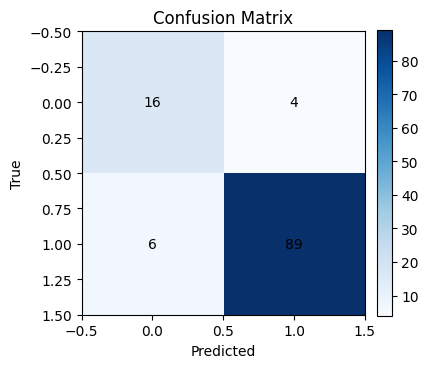

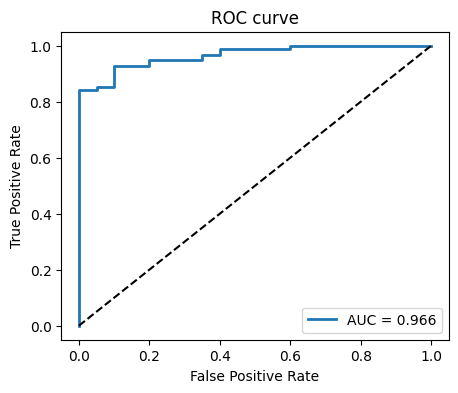

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_hat_mlp)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# ROC
fpr, tpr, thr = roc_curve(y_test, y_proba_mlp)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_score(y_test, y_proba_mlp):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(); plt.show()

```{admonition} Exercise 6.1
Pick a custom threshold `t` in `[0.3, 0.7]` and compute Accuracy, Precision, Recall, F1 at that threshold:

```python
t = 0.35
pred_custom = (y_proba_mlp >= t).astype(int)
# compute metrics
```
```

```{admonition} Exercise 6.2
Change `hidden_layer_sizes` to `(64,)` and then `(64, 32)`.  
Keep `alpha=1e-4`. Report Accuracy and AUC.
```

---

## 7. Training details you can control

```{admonition} Practical rules
- **Scale inputs**. Always wrap MLP in a `Pipeline` with `StandardScaler()`.
- **Use early stopping** for small to medium data. It guards against overfitting.
- **Start with one hidden layer**. Try sizes 16 to 128.
- **Try ReLU first**. Switch to `tanh` if signals look smooth or small networks struggle.
- **Alpha is L2 penalty**. Increase if the model overfits or is unstable.
- **Learning rate**. If loss bounces, reduce `learning_rate_init`. If training stalls, increase gradually.
```

### 7.1 Track training loss

Scikit-learn stores `loss_curve_` inside the `MLP*` estimator. We can access it via the pipeline.

In [23]:
mlp_est = mlp_tox.named_steps["mlp"]
loss_curve = getattr(mlp_est, "loss_curve_", None)
len(loss_curve) if loss_curve is not None else None

31

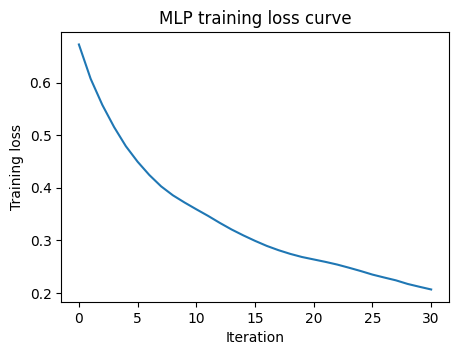

In [24]:
if loss_curve is not None:
    plt.figure(figsize=(5,3.5))
    plt.plot(loss_curve)
    plt.xlabel("Iteration"); plt.ylabel("Training loss")
    plt.title("MLP training loss curve")
    plt.show()
else:
    print("No loss curve found")

```{admonition} Exercise 7.1
Re-fit `mlp_tox` with `learning_rate_init=0.001` and `max_iter=1500`.  
Plot the new loss curve. Did it become smoother or just slower?
```

---

## 8. Quick theory box

- **Forward pass**: compute layer by layer \( a^{(l)} = \phi(W^{(l)} a^{(l-1)} + b^{(l)}) \).
- **Loss**:  
  - Regression uses MSE \( \frac{1}{n}\sum (y-\hat{y})^2 \).  
  - Binary classification uses log-loss \( -\frac{1}{n}\sum y\log p + (1-y)\log(1-p) \).
- **Backpropagation**: automatic differentiation computes gradients of loss with respect to all weights.
- **Optimizer**: gradient descent variants such as Adam update the weights to reduce loss.
- **Capacity vs generalization**: larger hidden layers reduce bias but can overfit. Early stopping, L2 penalty, and more data help.

```{admonition} Connection to earlier lectures
- Lecture 5 used linear models. An MLP is a stack of linear pieces plus activations.
- Lecture 6 tuned hyperparameters with CV. You can grid-search `hidden_layer_sizes` and `alpha` the same way.
- Lecture 7 showed nonlinear rules via trees. MLPs learn nonlinear functions too, but in a smooth way.
```

---

## 9. Mini hyperparameter sweep

We try a very small grid on **melting point** to observe trends. Keep it tiny so it runs in class.

### 9.1 Define a helper to train and score

In [25]:
def fit_score_mlp_reg(X_train, y_train, X_test, y_test, hls=(64,), act="relu", alpha=1e-4, lr=0.005, seed=0):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=hls,
            activation=act,
            alpha=alpha,
            learning_rate_init=lr,
            solver="adam",
            max_iter=800,
            early_stopping=True,
            validation_fraction=0.12,
            n_iter_no_change=25,
            random_state=seed
        ))
    ]).fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    return r2_score(y_test, y_hat), mean_absolute_error(y_test, y_hat)

### 9.2 Run a tiny grid

In [26]:
hls_grid = [(32,), (64,), (64, 32)]
alpha_grid = [1e-4, 1e-3]
rows = []
for h in hls_grid:
    for a in alpha_grid:
        r2, mae = fit_score_mlp_reg(X_train, y_train, X_test, y_test, hls=h, alpha=a)
        rows.append({"hidden_layer_sizes": h, "alpha": a, "R2": round(r2,3), "MAE": round(mae,2)})
pd.DataFrame(rows)

,hidden_layer_sizes,alpha,R2,MAE
0,"(32,)",0.0001,0.554,0.18
1,"(32,)",0.0010,0.554,0.18
2,"(64,)",0.0001,0.616,0.15
3,"(64,)",0.0010,0.616,0.15
4,"(64, 32)",0.0001,0.650,0.13
5,"(64, 32)",0.0010,0.706,0.11


```{admonition} Exercise 9.1
Add `activation="tanh"` to the helper and compare with `relu` for each `hidden_layer_sizes`.  
Summarize which setting is most consistent across seeds 0, 1, and 2.
```

---

## 10. Quick reference

```{admonition} API hints
- Regression: `MLPRegressor(hidden_layer_sizes=(64,), activation="relu", alpha=1e-4, early_stopping=True)`  
- Classification: `MLPClassifier(hidden_layer_sizes=(32,), activation="relu", alpha=1e-4, early_stopping=True)`  
- Always scale with `Pipeline([("scaler", StandardScaler()), ("mlp", ...)])`
- Loss curve: `estimator.loss_curve_` inside the pipeline via `named_steps["mlp"]`
```

```{admonition} Common settings to try
- hidden_layer_sizes: `(32,)`, `(64,)`, `(64, 32)`
- activation: `relu`, `tanh`
- alpha (L2): `1e-4`, `1e-3`, `1e-2`
- learning_rate_init: `0.001`, `0.005`
- early_stopping: `True` with `validation_fraction` around `0.1`
```

---

## 11. Glossary

```{glossary}
neuron
  Simple unit that applies a weighted sum plus bias, then an activation.
activation
  Nonlinear function such as relu, tanh, or sigmoid.
hidden layer
  Layer between inputs and outputs. Provides nonlinear capacity.
loss
  Function that measures fit quality. We minimize it during training.
backpropagation
  Automatic chain rule that computes gradients through layers.
early stopping
  Stop training when validation score stops improving.
alpha
  L2 regularization strength for MLP in scikit-learn.
learning rate
  Step size in the optimizer. Too high can diverge, too low can stall.
```

---

## 12. In‑class activity

Each task can be answered using code shown today. Fill in the `...` lines first. Solutions follow in Section 13.

### Q1. XOR with two hidden layers

Build an MLP for XOR with hidden sizes `(8, 8)` and `activation="tanh"`.  
Report accuracy and the confusion matrix.

In [27]:
# Q1 starter
X = X_xor
y = y_xor
mlp = MLPClassifier(hidden_layer_sizes=(8, 8), activation="tanh", solver="lbfgs", random_state=0)
mlp.fit(X, y)
pred = mlp.predict(X)
print("Acc:", accuracy_score(y, pred))
confusion_matrix(y, pred)

Acc: 1.0


array([[2, 0],
       [0, 2]], dtype=int64)

### Q2. Melting point MLP vs Ridge

Train two models on `MolWt, LogP, TPSA, NumRings` to predict Melting Point:
- Ridge with `alpha=1.0`
- MLPRegressor with `(64,)`, `relu`, `alpha=1e-3`, `early_stopping=True`

Report test R2 and MAE for both.

In [28]:
# Q2 starter
X = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]].values
y = df_reg["Melting Point"].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=7)

ridge = Ridge(alpha=1.0).fit(X_tr, y_tr)
y_r = ridge.predict(X_te)

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,), activation="relu",
                         alpha=1e-3, max_iter=800, early_stopping=True,
                         validation_fraction=0.12, random_state=7))
]).fit(X_tr, y_tr)
y_m = mlp.predict(X_te)

print(f"Ridge  R2={r2_score(y_te,y_r):.3f}  MAE={mean_absolute_error(y_te,y_r):.2f}")
print(f"MLP    R2={r2_score(y_te,y_m):.3f}  MAE={mean_absolute_error(y_te,y_m):.2f}")

Ridge  R2=0.860  MAE=16.17
MLP    R2=0.781  MAE=19.41


### Q3. Toxicity threshold tuning

Train `MLPClassifier` with `(32,)` and compute metrics at thresholds `0.3, 0.5, 0.7`.  
Which threshold gives Recall at least `0.80` with the best Precision?

In [29]:
# Q3 starter
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values
y = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).astype(int).values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,), activation="relu", alpha=1e-4,
                          max_iter=800, early_stopping=True, validation_fraction=0.12, random_state=1))
]).fit(X_tr, y_tr)

proba = clf.predict_proba(X_te)[:,1]
for t in [0.3, 0.5, 0.7]:
    pred = (proba >= t).astype(int)
    print(f"t={t:.1f}  Acc={accuracy_score(y_te,pred):.3f}  Prec={precision_score(y_te,pred):.3f}  Rec={recall_score(y_te,pred):.3f}  F1={f1_score(y_te,pred):.3f}")

t=0.3  Acc=0.835  Prec=0.833  Rec=1.000  F1=0.909
t=0.5  Acc=0.852  Prec=1.000  Rec=0.821  F1=0.902
t=0.7  Acc=0.322  Prec=1.000  Rec=0.179  F1=0.304


### Q4. Learning rate sweep for MP

Fix `(64,)`, `relu`, `alpha=1e-4`. Train with `learning_rate_init` in `[0.0005, 0.001, 0.005]`.  
Plot training loss curves and compare final test R2.

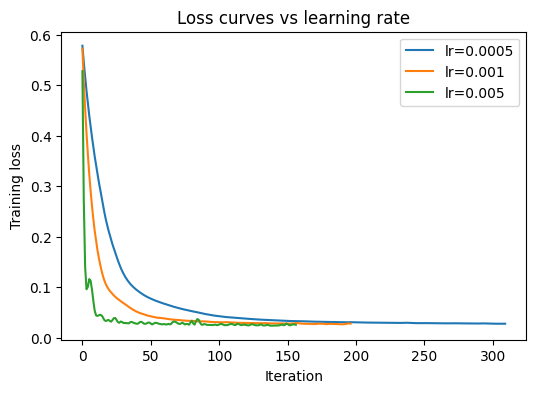

,lr,R2
0,0.0005,0.599346
1,0.0010,0.603090
2,0.0050,0.621330


In [30]:
# Q4 starter
rates = [0.0005, 0.001, 0.005]
histories = []
scores = []

for lr in rates:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(64,), activation="relu",
                             alpha=1e-4, learning_rate_init=lr, max_iter=1200,
                             early_stopping=True, validation_fraction=0.12,
                             n_iter_no_change=30, random_state=0))
    ]).fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    r2 = r2_score(y_test, y_hat)
    scores.append((lr, r2))
    histories.append((lr, pipe.named_steps["mlp"].loss_curve_))

plt.figure(figsize=(6,4))
for lr, curve in histories:
    plt.plot(curve, label=f"lr={lr}")
plt.xlabel("Iteration"); plt.ylabel("Training loss"); plt.legend(); plt.title("Loss curves vs learning rate")
plt.show()

pd.DataFrame(scores, columns=["lr", "R2"])

### Q5. Predict two new molecules

Use the fitted melting point MLP from Q2 to predict these descriptors:

- `[100, 1.5, 10, 2]`
- `[150, 2.0, 20, 3]`

In [31]:
# Q5 starter
X_new = np.array([[100, 1.5, 10, 2],
                  [150, 2.0, 20, 3]])
preds = mlp.predict(X_new)
pd.DataFrame(X_new, columns=["MolWt","LogP","TPSA","NumRings"]).assign(Predicted_MP=preds)

,MolWt,LogP,TPSA,NumRings,Predicted_MP
0,100.0,1.5,10.0,2.0,69.901376
1,150.0,2.0,20.0,3.0,83.869232


---

## 13. Solutions

### 13.1 Solution Q1

In [32]:
mlp = MLPClassifier(hidden_layer_sizes=(8, 8), activation="tanh", solver="lbfgs", random_state=0)
mlp.fit(X_xor, y_xor)
pred = mlp.predict(X_xor)
print("Acc:", accuracy_score(y_xor, pred))
confusion_matrix(y_xor, pred)

Acc: 1.0


array([[2, 0],
       [0, 2]], dtype=int64)

### 13.2 Solution Q2

In [33]:
X = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]].values
y = df_reg["Melting Point"].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=7)

ridge = Ridge(alpha=1.0).fit(X_tr, y_tr)
y_r = ridge.predict(X_te)

mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,), activation="relu",
                         alpha=1e-3, max_iter=800, early_stopping=True,
                         validation_fraction=0.12, random_state=7))
]).fit(X_tr, y_tr)
y_m = mlp.predict(X_te)

print(f"Ridge  R2={r2_score(y_te,y_r):.3f}  MAE={mean_absolute_error(y_te,y_r):.2f}")
print(f"MLP    R2={r2_score(y_te,y_m):.3f}  MAE={mean_absolute_error(y_te,y_m):.2f}")

Ridge  R2=0.860  MAE=16.17
MLP    R2=0.781  MAE=19.41


### 13.3 Solution Q3

In [34]:
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values
y = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).astype(int).values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(32,), activation="relu", alpha=1e-4,
                          max_iter=800, early_stopping=True, validation_fraction=0.12, random_state=1))
]).fit(X_tr, y_tr)
proba = clf.predict_proba(X_te)[:,1]
rows = []
for t in [0.3, 0.5, 0.7]:
    pred = (proba >= t).astype(int)
    rows.append({
        "thr": t,
        "Acc": round(accuracy_score(y_te,pred),3),
        "Prec": round(precision_score(y_te,pred),3),
        "Rec": round(recall_score(y_te,pred),3),
        "F1": round(f1_score(y_te,pred),3)
    })
pd.DataFrame(rows)

,thr,Acc,Prec,Rec,F1
0,0.3,0.835,0.833,1.000,0.909
1,0.5,0.852,1.000,0.821,0.902
2,0.7,0.322,1.000,0.179,0.304


### 13.4 Solution Q4

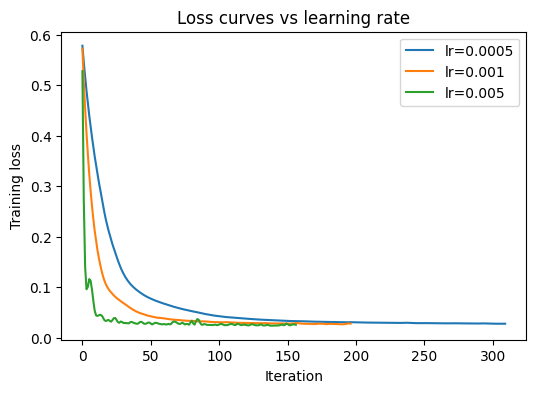

,lr,R2
0,0.0005,0.599346
1,0.0010,0.603090
2,0.0050,0.621330


In [35]:
rates = [0.0005, 0.001, 0.005]
histories = []
scores = []

for lr in rates:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(64,), activation="relu",
                             alpha=1e-4, learning_rate_init=lr, max_iter=1200,
                             early_stopping=True, validation_fraction=0.12,
                             n_iter_no_change=30, random_state=0))
    ]).fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    r2 = r2_score(y_test, y_hat)
    scores.append((lr, r2))
    histories.append((lr, pipe.named_steps["mlp"].loss_curve_))

plt.figure(figsize=(6,4))
for lr, curve in histories:
    plt.plot(curve, label=f"lr={lr}")
plt.xlabel("Iteration"); plt.ylabel("Training loss"); plt.legend(); plt.title("Loss curves vs learning rate")
plt.show()

pd.DataFrame(scores, columns=["lr", "R2"])

### 13.5 Solution Q5

In [36]:
X_new = np.array([[100, 1.5, 10, 2],
                  [150, 2.0, 20, 3]])
preds = mlp.predict(X_new)
pd.DataFrame(X_new, columns=["MolWt","LogP","TPSA","NumRings"]).assign(Predicted_MP=preds)

,MolWt,LogP,TPSA,NumRings,Predicted_MP
0,100.0,1.5,10.0,2.0,69.901376
1,150.0,2.0,20.0,3.0,83.869232


---

## 14. Extra practice ideas

- Replace the MP target with **log10(solubility + 1e-6)** and compare Ridge vs MLP.
- Try `activation="tanh"` for MP. Sometimes it fits smoother targets better.
- Stratified split on toxicity with a different seed and repeat threshold tuning.
- Use a tiny `GridSearchCV` over `hidden_layer_sizes` and `alpha` on MP. Keep the grid small to run quickly.